# Capacitance extraction problem revisited: Solving Laplace Equation with Finite Difference method in matricial form

It is possible to translate the problem of using the Laplace equation to compute the electric potential field to compute the capacitance of between the eletrodes of a coaxial cable to matricial form. In some cases, solving problems in the matricial problems can speed up the computation, trading the amount of computer memmory being used for computational speed: with higher RAM being used, you can also speed up calculations. This tradeoff can seem like a bad one, but when the expected computation time for a problem solving electromagnetics problems is something between 35 hours and a week, any speed up is welcome!

## Matricial Form of the Lapalce Equation:

Considering again the laplace equation for the potential, we have that:

$$ \nabla^2 \phi = \frac{\partial^2 \phi}{\partial x^2} +  \frac{\partial^2 \phi}{\partial y^2} = 0$$

Using the Finite Difference method to discretise the problem once again, and considering $f_{i,j} = \phi(ih, jh)$ we arrive at the conclusion that:

$$ f_{i,j} - \frac{1}{4} \left( f_{i-1,j} + f_{i,j-1} + f_{i,j+1} f_{i+1,j} \right) = 0 $$

Again, this has already been show in the ```ch3_3_1_finite_diff.ipynb``` notebook.

This equation can be directly extrapolated to matricial form, considering the $f_{i,j}$ terms as the unknowns of the linear system. The previous equation is then traslated to:

$$ \left[ \frac{-1}{4} \ \frac{-1}{4} \ 1 \ \frac{-1}{4} \ \frac{-1}{4}  \right] \cdot \left[ f_{i-1,j} \ f_{i,j-1} \ f_{i,j} \ f_{i,j+1} \ f_{i+1,j} \right]^T = 0 $$

Taking the matricial form for each point $(ih,jh)$ of the grid:

$$ A_{i,j} \cdot \vec{f}_{i,j} = b_{i,j} = 0 $$

The matricial form presented above is a localised matricial form, implemented through the use of a sub-group of elements belonging to the full matrix of stacked unknown electric potential values:

$$ \vec{f} = \left[ f_{1,1} \ f_{1,2} \ ... \ f_{1,N_y} \ f_{2,1} \ ... \ f_{N_x, N_y} \right]^T $$

To use the full stacked unknown electric potential vector, the matrix $A$ must also be extended by stacking the rows corresponding to the application of the Finite Difference method format of the Laplace equation: 

$$ 
A = \left[ \begin{matrix}
1 & -1/4 & 0 & 0 & ... \\
-1/4 & 1 & -1/4 & 0 & ... \\
0 & -1/4 & 1 & -1/4 & ... \\
0 & 0 & -1/4 & 1 & ...\\
... & ... & ... & ...
\end{matrix} \right]
$$

This leads to the full matrix form of the problem, where the vector $\vec{f}$ is updated in each iteration of the problem to converge to the target solution:

$$ \vec{0} = \vec{b} = A \cdot \vec{f} $$

It is also important ot notice that most of the elements of the matrix $A$ are zero - the matrix is sparse. This means that the matrix can be stored in a more efficient way, and that the computation of the matrix-vector product can be sped up by using the sparse matrix-vector product algorithm.

In [161]:
# Import required libraries
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import seaborn as sns

In [162]:
# Setup the domain of the problem
domain_bb = ((0,0),(1,1))
NP = 20
domain_np = (NP+1, NP+1)

x, y = np.meshgrid(
    np.linspace(
        domain_bb[0][0], 
        domain_bb[1][0], 
        domain_np[0]
    ), 
    np.linspace(
        domain_bb[0][1], 
        domain_bb[1][1], 
        domain_np[1]
    )
)

cond_bb = ((0.3,0.3),(0.7,0.7))
cond_np = (NP+1,NP+1)

xcond, ycond = np.meshgrid(
    np.linspace(
        cond_bb[0][0], 
        cond_bb[1][0], 
        cond_np[0]
    ), 
    np.linspace(
        cond_bb[0][1], 
        cond_bb[1][1], 
        cond_np[1]
    )
)

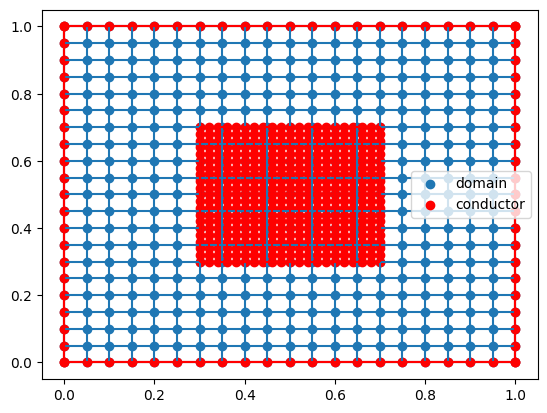

In [163]:
# Observe the domain
plt.scatter(x, y, label='domain')
plt.scatter(xcond, ycond, label='conductor', color='red')
# paint the border red as it is the conducting boundary
plt.scatter(x[0], y[0], color='red')
plt.scatter(x[-1], y[-1], color='red')
plt.scatter(x[:,0], y[:,0], color='red')
plt.scatter(x[:,-1], y[:,-1], color='red')
segs1 = np.stack((x,y), axis=2)
seg1cond = np.stack((xcond,ycond), axis=2)
segs2 = segs1.transpose(1,0,2)
seg2cond = seg1cond.transpose(1,0,2)
plt.gca().add_collection(LineCollection(segs1))
plt.gca().add_collection(LineCollection(seg1cond, color='red'))
plt.gca().add_collection(LineCollection(segs2))
plt.gca().add_collection(LineCollection(seg2cond, color='red'))
# Boundary conductor
plt.gca().add_collection(LineCollection([segs1[0], segs1[-1], segs1[:,-1], segs1[:,0]], color='red'))
plt.gca().add_collection(LineCollection([seg1cond[0], seg1cond[-1], seg1cond[:,-1], seg1cond[:,0]], color='red'))
plt.gca().add_collection(LineCollection([segs2[0], segs2[-1], segs2[:,-1], segs2[:,0]], color='red'))
plt.gca().add_collection(LineCollection([seg2cond[0], seg2cond[-1], seg2cond[:,-1], seg2cond[:,0]], color='red'))
plt.legend()
plt.show()

In [164]:
# Compute capacitance by updating the domain using the matricial formulation of the problem

def gauss_integral(f, n, m, hx, hy):
    """Compute the closed integral of f over the integration path."""
    integ = 0.0
    # integrate along the upper boundary
    for i in range(0, n):
        integ += 0.5*( f[i,m] + f[i+1,m] )
    # integrate along the right boundary
    for j in range(0, m):
        integ += 0.5*( f[n,j] + f[n,j+1] )
    
    # 4 symmetric quadrants
    return 4*integ
        

def capacitance(
    a: float,
    b: float,
    c: float,
    d: float,
    nx: int = 10,
    ny: int = 10,
    inner_cond_volt: float = 1.0,
    outter_cond_volt: float = 0.0,
    tol: float = 1e-4,
    max_iter: int = 2**10,
    verbose: bool = False
):
    """Compute the capacitance 
    per unit length of a coaxial 
    cable pair of rectangle conductors.

    Args:
        a (float): inner conductor width
        b (float): inner conductor height
        c (float): outter conductor width
        d (float): outter conductor height
        nx (int): number of points in the horizontal direction
        ny (int): number of points in the vertical direction
        inner_cond_volt (float, optional): voltage of the inner conductor. Defaults to 1.0.
        outter_cond_volt (float, optional): voltage of the outter conductor. Defaults to 0.0.
        tol (float, optional): relative tolerance for Gauss Seidel iteration. Defaults to 1e-6
        rel (float): relaxation parameter. Defaults to 2 - np.pi/n.
        max_iter (int, optional): maximum number of iterations. Defaults to 2**10.
    """
    hx = 0.5*c/nx
    hy = 0.5*d/ny
    na = round(0.5*a/hx)
    nb = round(0.5*b/hy)
    # linear spaces are only created for 
    # the top right quadrant of the whole domain, once 
    # we're assuming symmetry in the x and y directions
    x = np.linspace(0, 0.5*c, nx+1)
    y = np.linspace(0, 0.5*d, ny+1)
    
    # create A matrix for the linear system iteration
    center_diag = np.ones((nx+1) * (ny+1))
    top_diag = np.ones((nx+1) * (ny+1)) * -0.25
    bot_diag = np.ones((nx+1) * (ny+1)) * -0.25
    A = sp.sparse.diags(
        diagonals=[center_diag, top_diag, bot_diag],
        offsets=[0, 1, -1],
        shape=((nx+1) * (ny+1), (nx+1) * (ny+1)),
        format='csr'
    )
    #print(A)
    
    # create b vector for the linear system iteration
    b = np.zeros_like(center_diag)
    
    # boundary conditions
    pot = np.zeros((nx+1, ny+1))
    # mask of the conductor region, signaling one
    # volt on the inner conductor
    pot[0:na+2, 0:nb+2] = inner_cond_volt
    pot[0:nx+2, -1] = outter_cond_volt
    pot[-1, 0:ny+2] = outter_cond_volt
    # mask of the vacuum region, signaling one 
    # on the vacuum region and zero on the conductors regions
    #mask = np.ones((nx+1, ny+1))
    #mask[0:na+2, 0:nb+2] = 0
    
    # the number of eigenvalues to compute is the number of points in the domain 
    # minus the number of points in the conductor region set to a fixed value
    num_eigenvalues = (nx+1)*(ny+1) - (na+2)*(nb+2)
    
    # flatten the pot matrix into a vector  from 1,1 to 1,nx, ... , ny,1 to ny,nx
    f_vec = pot.flatten()
    #f_vec_mask = mask.flatten()
    
    # The system is of the form A*f = 0 (Homogeneous Linear System Equation), 
    # as such, compute the eigenvalues of A 
    # and check if the system is well conditioned
    cap = 0.0
    eig_vals, eig_vecs = sp.sparse.linalg.eigs(
        A, which='SM', return_eigenvectors=True,
        v0=f_vec, tol=tol, maxiter=max_iter
    )
    #print(eig_vals)
    #print(eig_vecs)
    
    # the solution is the sum of the eigenvalues times the eigenvectors
    sol = np.zeros_like(f_vec)
    caps = []
    # observe all solutions
    #fig, ax = plt.subplots((len(eig_vecs) + 1)//2, 2, figsize=(10, 10))
    for i in range(eig_vecs.shape[1]):
        sol = (eig_vecs[:,i].astype(float)*eig_vals[i]).astype(float)
        # reshape the C-style flattened vector into a matrix
        pot = sol.reshape((nx+1, ny+1))
        # compute charge per unit length using gauss theorem
        q = gauss_integral(pot, nx-1, ny-1, hx, hy)
        cap = q/(inner_cond_volt - outter_cond_volt)
        # compute cap in pF/m = 1e12*epsilon_0 = 8.854187
        cap = cap*8.854187
        caps.append(cap)
        if verbose:
            #plt.clf()
            #sns.heatmap(pot, ax=ax[i//2, i%2])
            pass
    return caps

/var/folders/vv/xctyh4bd2td6k2w_gvh_t2vr0000gn/T/ipykernel_67456/2619617708.py:109: ComplexWarning: Casting complex values to real discards the imaginary part
  sol = (eig_vecs[:,i].astype(float)*eig_vals[i]).astype(float)
/var/folders/vv/xctyh4bd2td6k2w_gvh_t2vr0000gn/T/ipykernel_67456/2619617708.py:109: ComplexWarning: Casting complex values to real discards the imaginary part
  sol = (eig_vecs[:,i].astype(float)*eig_vals[i]).astype(float)
/var/folders/vv/xctyh4bd2td6k2w_gvh_t2vr0000gn/T/ipykernel_67456/2619617708.py:109: ComplexWarning: Casting complex values to real discards the imaginary part
  sol = (eig_vecs[:,i].astype(float)*eig_vals[i]).astype(float)
/var/folders/vv/xctyh4bd2td6k2w_gvh_t2vr0000gn/T/ipykernel_67456/2619617708.py:109: ComplexWarning: Casting complex values to real discards the imaginary part
  sol = (eig_vecs[:,i].astype(float)*eig_vals[i]).astype(float)
/var/folders/vv/xctyh4bd2td6k2w_gvh_t2vr0000gn/T/ipykernel_67456/2619617708.py:109: ComplexWarning: Casting 

Capacitance: [-12.61805065480778, -0.02819862020930681, 0.2828331574890327, -0.36831185804098404, 0.3027532835766911, -0.09186052236984994] pF/m


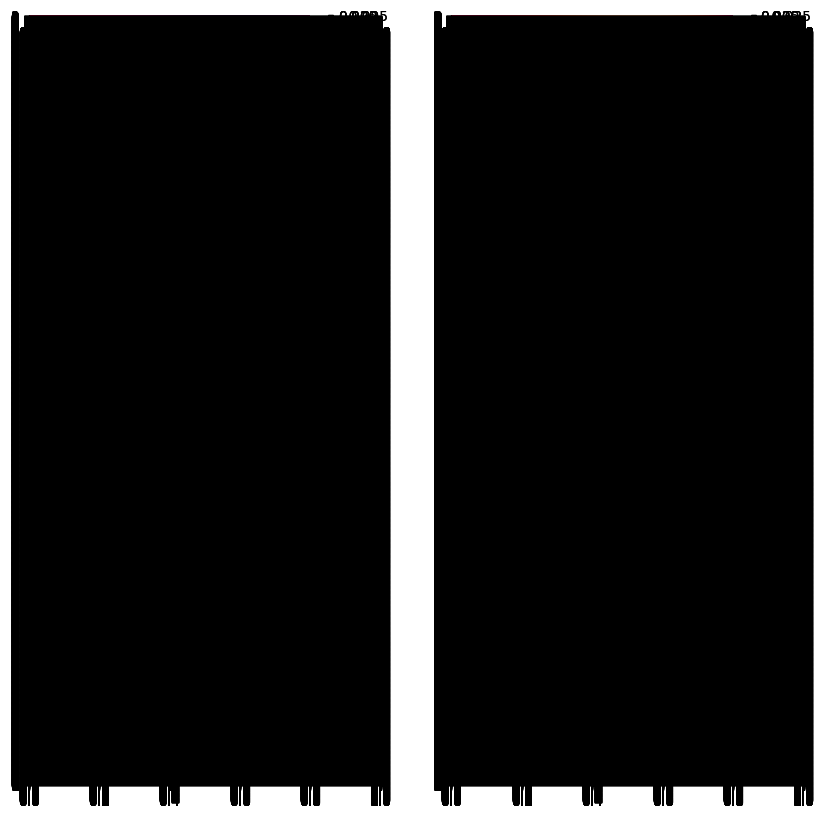

In [165]:
# test the capacitance extraction function
nx = 128
a = 1.0
b = 1.0
c = 2.0
d = 2.0
cap = 0.0
cap = capacitance(a, b, c, d, nx, nx, verbose=True, max_iter=2**10)
print(f'Capacitance: {cap} pF/m')